In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('../data/cleaned/full.csv', index_col=0)

In [3]:
target = 'Adj Close'
features = ['Open', 'High', 'Low', 'Close', 'Volume']
extra_features =

In [6]:
runs = [
    ('No Sentiment', []),
    ('GPT3.5 Sentiment', ['s_score', 'a_score']),
    ('Finbert Sentiment',  ['sentiment'])
]

In [9]:
for i, (name, extra_columns) in enumerate(runs):
    print(i)

0
1
2


In [4]:
y_ = df[target].values
X1_ = df[features].values
X2_ = df[features + extra_features]

In [5]:
feature_scaler1 = MinMaxScaler(feature_range=(0, 1))
X1 = feature_scaler1.fit_transform(X1_)

feature_scaler2 = MinMaxScaler(feature_range=(0, 1))
X2 = feature_scaler2.fit_transform(X2_)

target_scaler = MinMaxScaler(feature_range=(0, 1))
y = target_scaler.fit_transform(y_.reshape(-1, 1))

In [6]:
def create_sequences(features1, features2, target, time_steps):
    X1s, X2s, ys = [], [], []
    for i in range(len(features1) - time_steps):
        X1s.append(features1[i:(i + time_steps)])
        X2s.append(features2[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(X1s), np.array(X2s), np.array(ys)

X1, X2, y = create_sequences(X1, X2, y, 5)

In [7]:
X1_tensor = torch.tensor(X1, dtype=torch.float32)
X2_tensor = torch.tensor(X2, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [8]:
inds = np.arange(X1_tensor.shape[0])

In [9]:
test_size = 0.5
split_ind = int(inds.shape[0] * test_size)

In [10]:
X1_test = X1_tensor[inds[:split_ind]]
X1_train = X1_tensor[inds[split_ind:]]

X2_test = X2_tensor[inds[:split_ind]]
X2_train = X2_tensor[inds[split_ind:]]

y_test = y_tensor[inds[:split_ind]]
y_train = y_tensor[inds[split_ind:]]

In [11]:
# Create PyTorch DataLoaders
batch_size = 4
train_data1 = torch.utils.data.TensorDataset(X1_train, y_train)
train_loader1 = torch.utils.data.DataLoader(train_data1, shuffle=False, batch_size=batch_size)

test_data1 = torch.utils.data.TensorDataset(X1_test, y_test)
test_loader1 = torch.utils.data.DataLoader(test_data1, shuffle=False, batch_size=1)

train_data2 = torch.utils.data.TensorDataset(X2_train, y_train)
train_loader2 = torch.utils.data.DataLoader(train_data2, shuffle=False, batch_size=batch_size)

test_data2 = torch.utils.data.TensorDataset(X2_test, y_test)
test_loader2 = torch.utils.data.DataLoader(test_data2, shuffle=False, batch_size=1)

## Using LSTM


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, num_features, hidden_layer_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.num_features = num_features
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        
        # The LSTM takes feature sequences as inputs and outputs hidden states
        # with dimensionality hidden_layer_size.
        self.lstm = nn.LSTM(input_size=num_features,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers,
                            batch_first=True)
        
        # The linear layer that maps from hidden state space to output space
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Forward pass through LSTM layer
        # shapes (batch, seq_len, num_features)
        lstm_out, _ = self.lstm(input_seq)
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        # Here we use lstm_out[:, -1, :] just for the last time step
        last_time_step = lstm_out[:, -1, :]
        
        # Pass the last time step output to a Linear layer with 'output_size' units
        y_pred = self.linear(last_time_step)
        return y_pred

# Instantiate the model, define the loss function and the optimizer
num_features_1 = 5  # Number of features for each day in the sequence
num_features_2 = 7
hidden_layer_size = 50  # Number of features in hidden state
output_size = 1  # Predicting 'Adj Close'
num_layers = 2  # Number of recurrent layers

model_1 = LSTMModel(num_features_1, hidden_layer_size, output_size, num_layers)
model_2 = LSTMModel(num_features_2, hidden_layer_size, output_size, num_layers)

loss_function = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)

In [13]:
# Assume you have a model, loss_function, optimizer, train_loader defined
model_1.train()  # Set the model to training mode

num_epochs = 50
train_losses = []

for epoch in tqdm(range(num_epochs)):
    model_1.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader1:
        optimizer_1.zero_grad()  # Clear the gradients
        y_pred = model_1(X_batch)  # Forward pass: compute the output
        loss = loss_function(y_pred, y_batch)  # Compute the loss
        loss.backward()  # Backward pass: compute the gradient
        optimizer_1.step()  # Update the weights
        running_loss += loss.item() * X_batch.size(0)  # Multiply by batch size
    epoch_loss = running_loss / len(train_loader1.dataset)
    train_losses.append(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
# Assume you have a model, loss_function, optimizer, train_loader defined
model_2.train()  # Set the model to training mode

num_epochs = 50
train_losses = []

for epoch in tqdm(range(num_epochs)):
    model_2.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader2:
        optimizer_2.zero_grad()  # Clear the gradients
        y_pred = model_2(X_batch)  # Forward pass: compute the output
        loss = loss_function(y_pred, y_batch)  # Compute the loss
        loss.backward()  # Backward pass: compute the gradient
        optimizer_2.step()  # Update the weights
        running_loss += loss.item() * X_batch.size(0)  # Multiply by batch size
    epoch_loss = running_loss / len(train_loader2.dataset)
    train_losses.append(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

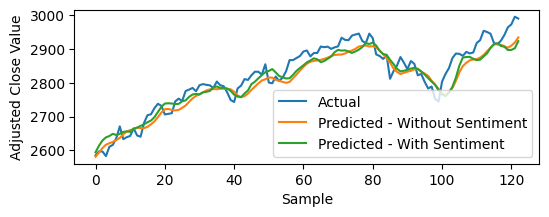

In [17]:
# Set the model to evaluation mode
model_1.eval()

# To track the actuals and predictions
actuals = []
predictions = []

with torch.no_grad():  # No need to track the gradients
    for X_batch, y_batch in test_loader1:
        # Forward pass: compute predicted y by passing X to the model.
        y_test_pred = model_1(X_batch)
        
        # Store predictions and actuals for later analysis
        actuals.extend(y_batch.numpy())
        predictions.extend(y_test_pred.numpy())

# Convert lists to numpy arrays
actuals = np.array(actuals)
predictions = np.array(predictions)

# Inverse transform the predictions and actuals
actuals_scaled_back = target_scaler.inverse_transform(actuals)
predictions_scaled_back = target_scaler.inverse_transform(predictions)


# Set the model to evaluation mode
model_2.eval()

# To track the actuals and predictions
actuals_2 = []
predictions_2 = []

with torch.no_grad():  # No need to track the gradients
    for X_batch, y_batch in test_loader2:
        # Forward pass: compute predicted y by passing X to the model.
        y_test_pred = model_2(X_batch)
        
        # Store predictions and actuals for later analysis
        actuals_2.extend(y_batch.numpy())
        predictions_2.extend(y_test_pred.numpy())

# Convert lists to numpy arrays
actuals_2 = np.array(actuals_2)
predictions_2 = np.array(predictions_2)

# Inverse transform the predictions and actuals
actuals_scaled_back_2 = target_scaler.inverse_transform(actuals_2)
predictions_scaled_back_2 = target_scaler.inverse_transform(predictions_2)

# Plotting
plt.figure(figsize=(6, 2))
plt.plot(actuals_scaled_back, label='Actual')
plt.plot(predictions_scaled_back - 100, label='Predicted - Without Sentiment')
plt.plot(predictions_scaled_back_2 - 100, label='Predicted - With Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()

plt.savefig('../imgs/LSTM_pred.png')
plt.show()


In [18]:
# Set the model to evaluation mode
model.eval()

# To track the actuals and predictions
actuals = []
predictions = []

with torch.no_grad():  # No need to track the gradients
    for X_batch, y_batch in test_loader1:
        # Forward pass: compute predicted y by passing X to the model.
        y_test_pred = model(X_batch)
        
        # Store predictions and actuals for later analysis
        actuals.extend(y_batch.numpy())
        predictions.extend(y_test_pred.numpy())

# Convert lists to numpy arrays
actuals = np.array(actuals)
predictions = np.array(predictions)

# Inverse transform the predictions and actuals
actuals_scaled_back = target_scaler.inverse_transform(actuals)
predictions_scaled_back = target_scaler.inverse_transform(predictions)


# Set the model to evaluation mode
model_2.eval()

# To track the actuals and predictions
actuals_2 = []
predictions_2 = []

with torch.no_grad():  # No need to track the gradients
    for X_batch, y_batch in test_loader2:
        # Forward pass: compute predicted y by passing X to the model.
        y_test_pred = model_2(X_batch)
        
        # Store predictions and actuals for later analysis
        actuals_2.extend(y_batch.numpy())
        predictions_2.extend(y_test_pred.numpy())

# Convert lists to numpy arrays
actuals_2 = np.array(actuals_2)
predictions_2 = np.array(predictions_2)

# Inverse transform the predictions and actuals
actuals_scaled_back_2 = target_scaler.inverse_transform(actuals_2)
predictions_scaled_back_2 = target_scaler.inverse_transform(predictions_2)

# Plotting
plt.figure(figsize=(6, 2))
plt.plot(actuals_scaled_back, label='Actual')
plt.plot(predictions_scaled_back - 100, label='Predicted - Without Sentiment')
plt.plot(predictions_scaled_back_2 - 100, label='Predicted - With Sentiment')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Value')
plt.legend()

plt.savefig('../imgs/RNN_pred.png')

plt.show()

NameError: name 'model' is not defined